In [11]:
import pywavefront
import numpy as np
import os
import sys
import rclpy
import numpy as np
import scipy.sparse as spa
from scipy.linalg import block_diag
import osqp
from pykdtree.kdtree import KDTree
from matplotlib.pyplot import plot as plot

from matplotlib.pyplot import scatter as scatter
if '/home/paul/CLionProjects/thesis_nerf/scripts' not in sys.path:
    sys.path.append('/home/paul/CLionProjects/thesis_nerf/scripts')
if not rclpy.ok():
    rclpy.init()
from point_cloud_utils import send_point_cloud
    
def send_points(points, color, topic):
    if color.size==3:
        colors = np.zeros(points.shape)+color
    else:
        colors = color
    rgb_points = np.hstack((points, colors))
    send_point_cloud(rgb_points, has_alpha=False,topic=topic)

def get_vert_np():
#     obj = 'truck.obj'
    obj = 'block.obj'
#     obj = 'monkey.obj'
#     obj = 'long.obj'
    scene = pywavefront.Wavefront(obj, parse=True)
    verts = np.array(scene.vertices)
    if verts.shape[0] > 10000:
        inds = np.linspace(0, verts.shape[0]-1, 10000, dtype=np.int32)
        verts = verts[inds, :]
    return verts

def radial_basis(x, centers, width):
    # spatial axis is 0, dim axis is 1 
    assert(len(centers.shape)==len(x.shape))
    assert(len(centers.shape)==2)
    assert(centers.shape[1]==x.shape[1])
    num_dims = x.shape[1]
    num_centers = centers.shape[0]
    num_x = x.shape[0]
    center_shape = [1, num_dims, num_centers]
    centers = np.reshape(centers, center_shape)
    x_shape = [num_x, num_dims, 1]
    x = np.reshape(x, x_shape)
    
    dist = (x - centers)**2
    dist = np.sqrt(np.sum(dist, axis=1))
    mVal = np.exp(-1/width*dist**2);
    
    return mVal

def radial_basis_d(x, centers, width):
    # spatial axis is 0, dim axis is 1 
    assert(len(centers.shape)==len(x.shape))
    assert(len(centers.shape)==2)
    assert(centers.shape[1]==x.shape[1])
    num_dims = x.shape[1]
    num_centers = centers.shape[0]
    num_x = x.shape[0]
    center_shape = [1, num_dims, num_centers]
    centers = np.reshape(centers, center_shape)
    x_shape = [num_x, num_dims, 1]
    x = np.reshape(x, x_shape)
    
    dist = (x - centers)**2
    dist = np.sqrt(np.sum(dist, axis=1))
    mVal = -((2/width)*dist)*np.exp(-(1/width)*dist**2);

    return mVal

def radial_basis_dd(x, centers, width):
    # spatial axis is 0, dim axis is 1 
    assert(len(centers.shape)==len(x.shape))
    assert(len(centers.shape)==2)
    assert(centers.shape[1]==x.shape[1])
    num_dims = x.shape[1]
    num_centers = centers.shape[0]
    num_x = x.shape[0]
    center_shape = [1, num_dims, num_centers]
    centers = np.reshape(centers, center_shape)
    x_shape = [num_x, num_dims, 1]
    x = np.reshape(x, x_shape)
    
    dist = (x - centers)**2
    dist = np.sqrt(np.sum(dist, axis=1))
    mVal = ((4/(width**2))*dist**2 - 2/width)*np.exp(-1/width*dist**2);

    return mVal

def radial_basis_cyclic(x, centers, width):
    mVal = radial_basis(x, centers, width)
    center_2 = .5*np.ones((1, x.shape[1]))
    width_2 = 1/30;
    mVal = mVal*radial_basis(x, center_2, width_2)
    
    return mVal

def radial_basis_dd_cyclic(x, centers, width):
    center_2 = .5*np.ones((1, x.shape[1]))
    width_2 = 1/30;
    scale = radial_basis(x, center_2, width_2)
    mVal = radial_basis(x, centers, width)
    
    mVal_d = radial_basis_d(x, centers, width)
    mVal_dd = radial_basis_dd(x, centers, width)
    
    scale_d = radial_basis_d(x, center_2, width_2)
    scale_dd = radial_basis_dd(x, center_2, width_2)
    
#     f(x) = g(x)*h(x)
#     f'(x) = g'(x)*h(x)+g(x)*h'(x)
#     f''(x) = g''(x)*h(x) + g'(x)*h'(x) + g'(x)*h'(x) + g(x)*h''(x)
#     f''(x) = g''(x)*h(x) + 2g'(x)*h'(x) + g(x)*h''(x)
    
    return mVal_dd*scale + 2*mVal_d*scale_d+mVal*scale_dd


def quadprog(P, q, G=None, h=None, A=None, b=None,
             initvals=None, verbose=True):
    l = -np.inf * np.ones(len(h))
    if A is not None:
        qp_A = spa.vstack([G, A]).tocsc()
        qp_l = np.hstack([l, b])
        qp_u = np.hstack([h, b])
    else:  # no equality constraint
        qp_A = G
        qp_l = l
        qp_u = h
    model = osqp.OSQP()
    model.setup(P=P, q=q,
                A=qp_A, l=qp_l, u=qp_u, verbose=verbose)
    if initvals is not None:
        model.warm_start(x=initvals)
    results = model.solve()
    return results.x, results.info.status

vert_np = get_vert_np()
# vert_np[:,1] += .5

Unimplemented OBJ format statement 's' on line 's 0'


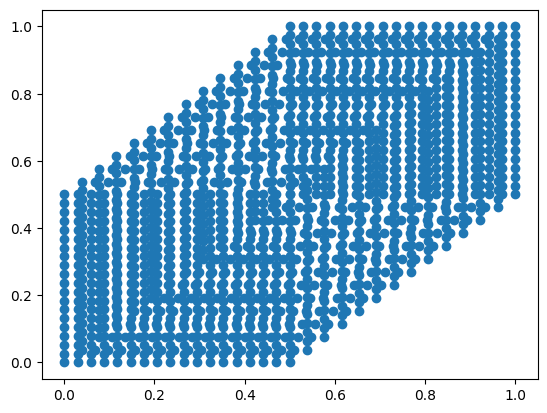

In [12]:
uv = np.zeros((vert_np.shape[0], 2))
uv[:,:2] = vert_np[:,:2] + np.reshape(vert_np[:,2],(-1,1))
uv = uv-np.min(uv)
uv = uv/np.max(uv)
uv_model = uv

color = np.zeros((vert_np.shape))
color[:, 1:3] = uv
send_points(vert_np, color, topic='point_cloud')

scatter(uv[:, 0], uv[:, 1])



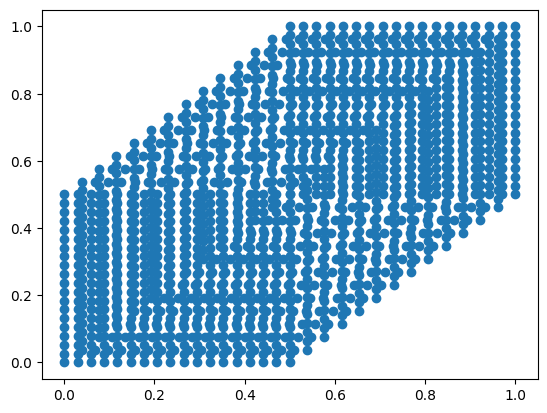

In [13]:
def get_A(uv, cx, cy):
    xv, yv = np.meshgrid(cx, cy, indexing='xy')
    centers = np.reshape(np.hstack((xv.flatten(), yv.flatten())), (-1, 2))
    Ax = np.ones((uv.shape[0], len(cx)*len(cy)+1))
    Ax[:, :len(cx)*len(cy)] = radial_basis(uv, centers, .1)
    Ay = Ax
    Az = Ax
    return block_diag(Ax, Ay, Az)

def get_Add(uv, cx, cy):
    xv, yv = np.meshgrid(cx, cy, indexing='xy')
    centers = np.reshape(np.hstack((xv.flatten(), yv.flatten())), (-1, 2))
    Ax = np.zeros((uv.shape[0], len(cx)*len(cy)+1))
    Ax[:, :len(cx)*len(cy)] = radial_basis_dd(uv, centers, .1)
    Ay = Ax
    Az = Ax
    return block_diag(Ax, Ay, Az)


# plot uv
scatter(uv_model[:, 0], uv_model[:, 1])

for i in range(100):
    x = np.linspace(0, 1, 80)
    y = np.linspace(0, 1, 80)
    xv, yv = np.meshgrid(x, y, indexing='xy')
    uv_grid = np.reshape(np.hstack((xv.flatten(), yv.flatten())) , (2, -1)).transpose()
    uv_grid_full = uv_grid 
    cx = np.linspace(-.1, 1.1, 10)
    cy = np.linspace(-.1, 1.1, 10)
    
#     dist = np.mean(dist, axis=1)
#     1)
    
#     uv_model = (uv_model-.5)*0.99+.5
    kd_tree = KDTree(uv_model)
    dist, idx = kd_tree.query(uv_grid, k=2)
    vert_np_grid  = vert_np[idx,:]
    vert_np_grid = np.mean(vert_np_grid, axis=1)
    dist = np.mean(dist, axis=1)
    dist_uv_thresh = .1
    cond = dist < dist_uv_thresh
#     vert_np_grid = vert_np_grid[cond, :]
#     uv_grid = uv_grid[cond, :]
#     uv_grid_full = uv_grid_full[1-cond, :]
        
    A = get_A(uv_grid, cx, cy)
    A_full = get_Add(uv_grid_full, cx, cy)
    b = np.reshape(vert_np_grid.transpose(), (-1,1))
    b_full = np.zeros((A_full.shape[0], 1))
    alpha = 0.001
    alpha_2 = .01
    A_reg = np.vstack((A, alpha_2*A_full, alpha*np.eye(A.shape[1])))
    b_reg = np.vstack((b, b_full, alpha*np.ones((A.shape[1],1))))
    H =  A_reg.transpose() @ A_reg
    f =  -A_reg.transpose() @ b_reg
    q0 = np.ones(len(f))


    model = osqp.OSQP()
    model.setup(P=spa.coo_matrix(H), q=f, verbose=False)
    model.warm_start(x=q0)
    results = model.solve()
    w = results.x
    assert(results.info.status=='solved')


    # A = get_A(uv_model, cx, cy)
    # verts_model = A@w
    # verts_model = np.reshape(verts_model, (3, -1)).transpose()
    # color = np.zeros((vert_np.shape))
    # color[:, 1:3] = uv
    # color[:,0]=.5
    # send_points(verts_model, color, topic='point_cloud_2')


    A = get_A(uv_grid, cx, cy)
    verts_model = A@w
    verts_model = np.reshape(verts_model, (3, -1)).transpose()
    if i % 10 ==0:
        uv_grid_vis = np.reshape(np.hstack((xv.flatten(), yv.flatten())) , (2, -1)).transpose()
        A_vis = get_A(uv_grid_vis, cx, cy)
        verts_model_vis = A_vis@w
        verts_model_vis = np.reshape(verts_model_vis, (3, -1)).transpose()
        send_points(verts_model_vis, np.array([0, .9, 0]), topic='point_cloud_2')

    kd_tree = KDTree(verts_model)
    dist, idx = kd_tree.query(vert_np, k=64)
    uv_model = uv_grid[idx,:]
    uv_model = np.mean(uv_model,axis=1)

In [ ]:
kd_tree = KDTree(verts_model_vis)
dist, idx = kd_tree.query(vert_np, k=2)
uv_model = np.mean(uv_grid_vis[idx,:],axis=1)
scatter(uv_model[:, 0], uv_model[:, 1])

In [ ]:
x = np.linspace([0], [1], 100)
centers = np.linspace([0], [1], 10)
A = radial_basis_cyclic(x, centers, .1)
plot(A)

In [ ]:
# visualize basis
x = np.linspace(0, 1, 80)
y = np.linspace(0, 1, 80)
xv, yv = np.meshgrid(x, y, indexing='xy')
X = np.reshape(np.hstack((xv.flatten(), yv.flatten())) , (2, -1)).transpose()

x = np.linspace(0, 1, 2)
y = np.linspace(0, 1, 2)
xv, yv = np.meshgrid(x, y, indexing='xy')
centers = np.reshape(np.hstack((xv.flatten(), yv.flatten())), (-1,2))
A = radial_basis(X, centers, .1)


points = []
color = []
for i in range(A.shape[1]):
    points.append(np.hstack((X, np.expand_dims(A[:,i],1))))
    c = np.random.normal([0,0,0], [1,1,1], 3)
    c = abs(c)/np.linalg.norm(c)
    color.append(c*np.ones(points[-1].shape))

    
points = np.vstack(points)
color = np.vstack(color)
send_points(points, color,topic='point_cloud_2')


In [ ]:
verts_model.shape